In [83]:
%pip install matplotlib
%pip install numpy
%pip install pandas
%pip install pyarrow

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

In [3]:
base_path = '../data/'
file_paths = os.listdir(base_path)
# read data
origin_dfs = []
for file in file_paths:
    if len(file) < 10: #.DS_store
        continue
    
    df_tmp = pd.read_parquet(os.path.join(base_path, file))
    origin_dfs.append(df_tmp)

origin_df = pd.concat(origin_dfs)

In [86]:
# print(origin_df[['slot','block_number', 'value']]) 

In [4]:

# filter data
max_epoch = 299277
min_epoch = 234678
slots_per_epoch = 32
max_slot = 9576895
min_slot = 7509696

# drop duplicates
df = origin_df.drop_duplicates(subset='slot', keep='first').reset_index(drop=True)

# Filter the DataFrame to include only rows where payload_delivered is True and slot is less than or equal to max_slot
df = df[(df['payload_delivered'] == True) & (df['slot'] <= max_slot) & (df['slot'] >= min_slot)]

df.sort_values(by=['slot'], ascending=False, inplace=True)
df.reset_index(inplace=True, drop=True)

# add epoch field
df['epoch'] = max_epoch - ((max_slot - df['slot']) // slots_per_epoch)

# add slot_num field: from 32 to 1
df['slot_num'] = df.groupby('epoch')['slot'].rank(method='first', ascending=False).astype(int)
df['slot_num'] = 33 - df['slot_num']

print(df[['slot','block_number', 'value', 'epoch','slot_num']].head(32)) 

         slot  block_number                   value     epoch  slot_num
0   9576895.0      20369984   4.174411855889905e+16  299277.0        32
1   9576894.0      20369983  3.1597728887506376e+16  299277.0        31
2   9576893.0      20369982   4.953250898900484e+16  299277.0        30
3   9576892.0      20369981   3.656861828574943e+16  299277.0        29
4   9576891.0      20369980  1.5501143142722112e+17  299277.0        28
5   9576890.0      20369979  1.4126204649757352e+17  299277.0        27
6   9576889.0      20369978  1.4063185235585944e+17  299277.0        26
7   9576888.0      20369977  4.6666261422941304e+16  299277.0        25
8   9576887.0      20369976  5.2757909519351464e+16  299277.0        24
9   9576886.0      20369975   4.376420595839795e+16  299277.0        23
10  9576885.0      20369974   3.505043626463598e+16  299277.0        22
11  9576884.0      20369973   7.863838626936005e+16  299277.0        21
12  9576883.0      20369972  6.5434576552072536e+16  299277.0   

In [88]:
# deal with those scientific numbers
df['value'] = pd.to_numeric(df['value'], errors='coerce').fillna(0)
# Aggregate the 'value' for each epoch and slot number combination
aggregated_df = df.groupby(['epoch', 'slot_num', 'block_number'])['value'].sum().reset_index()

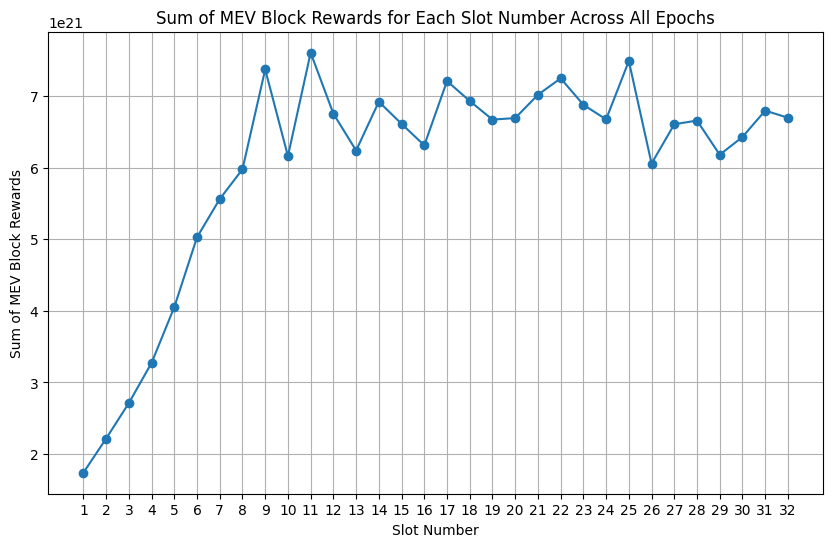

In [89]:
# Calculate the sum of 'value' for each slot_num across all epochs
slot_num_sums = aggregated_df.groupby('slot_num')['value'].sum().reindex(range(1, slots_per_epoch+1)).fillna(0).values
# Plotting the array
plt.figure(figsize=(10, 6))
plt.plot(range(1, slots_per_epoch + 1), slot_num_sums, marker='o')
plt.title('Sum of MEV Block Rewards for Each Slot Across All Epochs')
plt.xlabel('Slot')
plt.ylabel('Sum of MEV Block Rewards')
plt.xticks(range(1, slots_per_epoch + 1))
plt.grid(True)
plt.show()

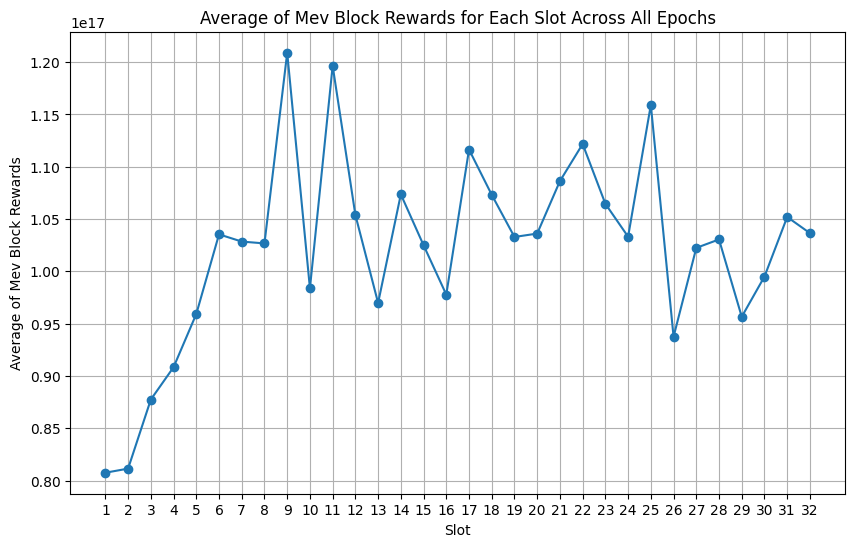

In [90]:
# average of mev rewards
# Calculate the average of 'value' for each slot_num across all epochs
slot_num_avgs = aggregated_df.groupby('slot_num')['value'].mean().reindex(range(1, slots_per_epoch + 1), fill_value=0).values
# Plotting the array
plt.figure(figsize=(10, 6))
plt.plot(range(1, slots_per_epoch + 1), slot_num_avgs, marker='o')
plt.title('Average of Mev Block Rewards for Each Slot Across All Epochs')
plt.xlabel('Slot')
plt.ylabel('Average of Mev Block Rewards')
plt.xticks(range(1, slots_per_epoch + 1))
plt.grid(True)
plt.show()